In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import os
import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.filterwarnings('ignore')


C:\Users\Rajamula\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Rajamula\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')
submission_df=pd.read_csv('sample.csv')

In [3]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [10]:
train_df.isnull().sum(), test_df.isnull().sum()   #checking null values in train and test data

(id                      0
 Gender                  0
 Age                     0
 Driving_License         0
 Region_Code             0
 Previously_Insured      0
 Vehicle_Age             0
 Vehicle_Damage          0
 Annual_Premium          0
 Policy_Sales_Channel    0
 Vintage                 0
 Response                0
 dtype: int64,
 id                      0
 Gender                  0
 Age                     0
 Driving_License         0
 Region_Code             0
 Previously_Insured      0
 Vehicle_Age             0
 Vehicle_Damage          0
 Annual_Premium          0
 Policy_Sales_Channel    0
 Vintage                 0
 dtype: int64)

In [5]:
train_df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [6]:
train_df.shape, test_df.shape    #shape of data

((381109, 12), (127037, 11))

In [20]:
train_df['Response'].value_counts()/train_df['Response'].shape #target variable response
# 0- not taken
#1- taken

0    0.877437
1    0.122563
Name: Response, dtype: float64

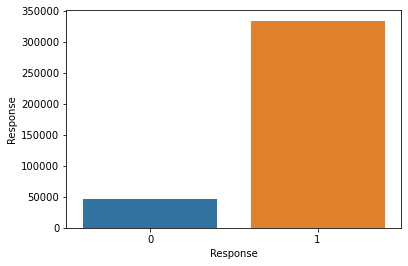

In [90]:
sns.barplot(train_df['Response'],train_df['Response'].value_counts())  #visualizing target variable

In [11]:
train_df.dtypes, test_df.dtypes   #data types

(id                        int64
 Gender                   object
 Age                       int64
 Driving_License           int64
 Region_Code             float64
 Previously_Insured        int64
 Vehicle_Age              object
 Vehicle_Damage           object
 Annual_Premium          float64
 Policy_Sales_Channel    float64
 Vintage                   int64
 Response                  int64
 dtype: object,
 id                        int64
 Gender                   object
 Age                       int64
 Driving_License           int64
 Region_Code             float64
 Previously_Insured        int64
 Vehicle_Age              object
 Vehicle_Damage           object
 Annual_Premium          float64
 Policy_Sales_Channel    float64
 Vintage                   int64
 dtype: object)

# **Basic EDA**

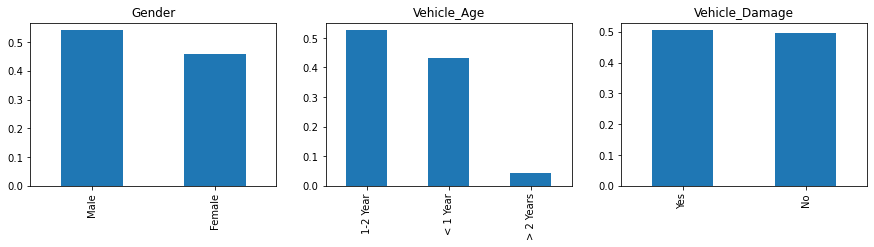

In [40]:
# categorical variables visualization
plt.figure(1)
plt.subplot(131)
train_df['Gender'].value_counts(normalize=True).plot.bar(figsize= (15,3), title= 'Gender')
plt.subplot(132)
train_df['Vehicle_Age'].value_counts(normalize=True).plot.bar(figsize= (15,3), title= 'Vehicle_Age')
plt.subplot(133)
train_df['Vehicle_Damage'].value_counts(normalize=True).plot.bar(figsize= (15,3), title= 'Vehicle_Damage')


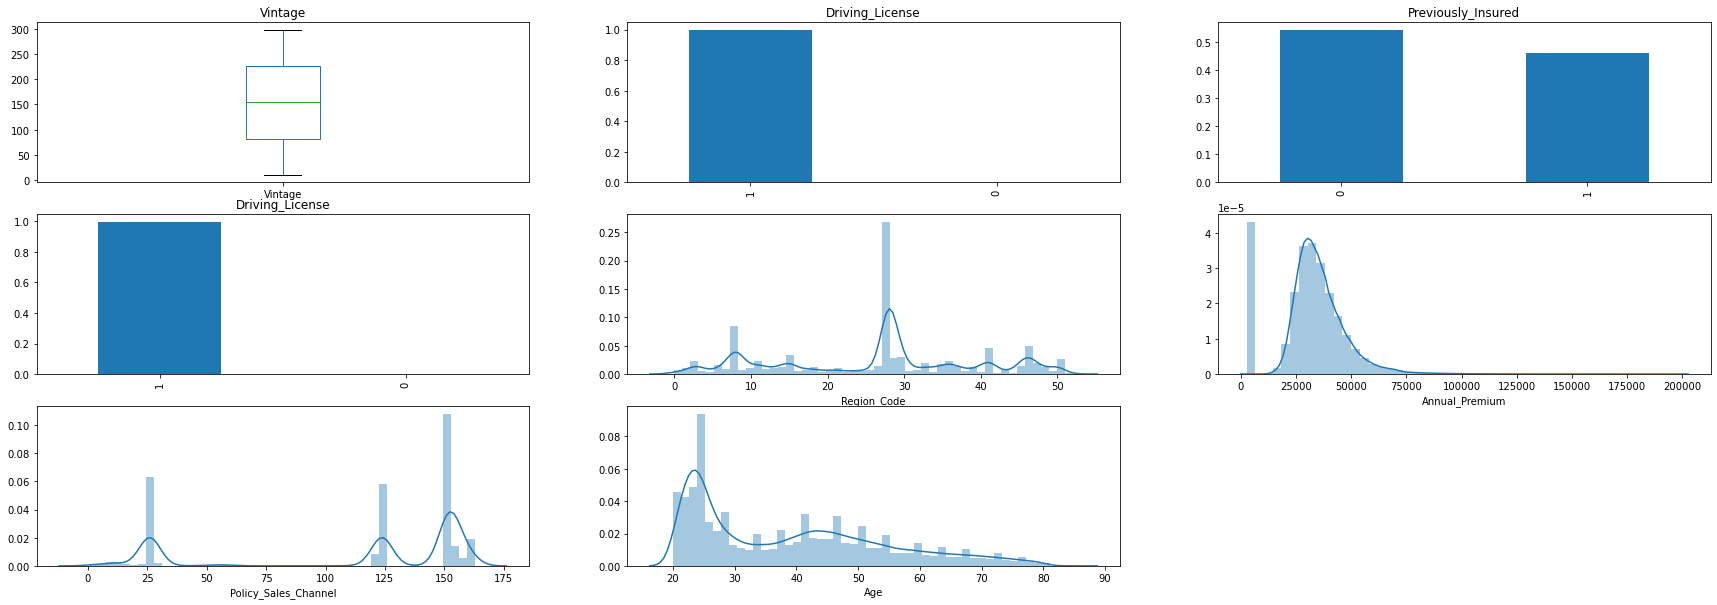

In [84]:
#numerical variables visualization
plt.figure(1)
plt.subplot(331)
train_df['Vintage'].plot.box(figsize= (30,10), title= 'Vintage')
plt.subplot(332)
train_df['Driving_License'].value_counts(normalize=True).plot.bar(figsize= (30,10), title= 'Driving_License')
plt.subplot(333)
train_df['Previously_Insured'].value_counts(normalize=True).plot.bar(figsize= (30,10), title= 'Previously_Insured')
plt.subplot(334)
train_df['Driving_License'].value_counts(normalize=True).plot.bar(figsize= (30,10), title= 'Driving_License')
plt.subplot(335)
sns.distplot(train_df['Region_Code'])
plt.subplot(336)
sns.distplot(train_df['Annual_Premium'])
plt.subplot(337)
sns.distplot(train_df['Policy_Sales_Channel'])
plt.subplot(338)
sns.distplot(train_df['Age'])

plt.show()

In [85]:
#Since in Test data there is no Annual Premium value greater than 2 lakh
train_df=train_df[train_df['Annual_Premium']<200000]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380997 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    380997 non-null  int64  
 1   Gender                380997 non-null  object 
 2   Age                   380997 non-null  int64  
 3   Driving_License       380997 non-null  int64  
 4   Region_Code           380997 non-null  float64
 5   Previously_Insured    380997 non-null  int64  
 6   Vehicle_Age           380997 non-null  object 
 7   Vehicle_Damage        380997 non-null  object 
 8   Annual_Premium        380997 non-null  float64
 9   Policy_Sales_Channel  380997 non-null  float64
 10  Vintage               380997 non-null  int64  
 11  Response              380997 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 37.8+ MB


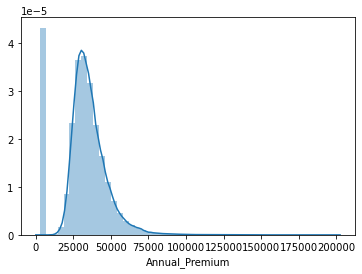

In [86]:
sns.distplot(train_df['Annual_Premium'])

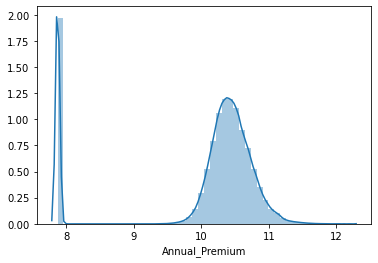

In [87]:
#Data is left Skewed as we can see from above distplot
train_df['Annual_Premium']=np.log(train_df['Annual_Premium'])
sns.distplot(train_df['Annual_Premium'])

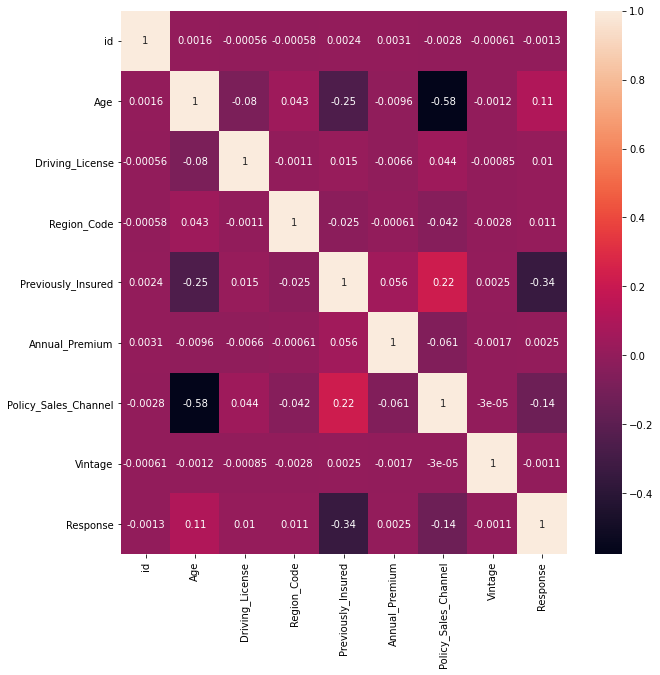

In [89]:
#Checking correlation between features
plt.figure(figsize=(10,10))
sns.heatmap(train_df.corr(),annot=True)

# **Preprocessing**

In [92]:
combine_set=pd.concat([train_df,test_df])
le=LabelEncoder()
combine_set['Gender']=le.fit_transform(combine_set['Gender'])
combine_set['Vehicle_Damage']=le.fit_transform(combine_set['Vehicle_Damage'])

fe=combine_set.groupby('Vehicle_Age').size()/len(combine_set)
combine_set['Vehicle_Age']=combine_set['Vehicle_Age'].apply(lambda x: fe[x])#can even try Label encoding or OHE
fe
combine_set.head(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28.0,0,0.041960,1,10.607921,26.0,217,1.0
1,2,1,76,1,3.0,0,0.525449,0,10.420375,26.0,183,0.0
2,3,1,47,1,28.0,0,0.041960,1,10.553049,26.0,27,1.0
3,4,1,21,1,11.0,1,0.432591,0,10.261826,152.0,203,0.0
4,5,0,29,1,41.0,1,0.432591,0,10.221796,152.0,39,0.0


In [94]:
#Data set Preparation
train_df=combine_set[combine_set['Response'].isnull()==False]
test_df=combine_set[combine_set['Response'].isnull()==True]
X=train_df.drop(['id','Response'],axis=1)
y=train_df['Response'] 
X_main_test=test_df.drop(['id','Response'],axis=1)

X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=294)

# **LGBM**

In [95]:
lg=LGBMClassifier(boosting_type='gbdt',n_estimators=500,depth=10,learning_rate=0.04,objective='binary',metric='auc',is_unbalance=True,
                 colsample_bytree=0.5,reg_lambda=2,reg_alpha=2,random_state=294,n_jobs=-1)

lg.fit(X_train,y_train)
print(roc_auc_score(y_val,lg.predict_proba(X_val)[:,1]))

0.8578961470556977


In [99]:
#Check for Permutation Importance of Features
perm = PermutationImportance(lg,random_state=294).fit(X_val, y_val)
eli5.show_weights(perm,feature_names=X_val.columns.tolist())

Weight,Feature
0.0118 ± 0.0014,Age
0.0102 ± 0.0009,Vehicle_Age
0.0101 ± 0.0009,Region_Code
0.0020 ± 0.0003,Gender
0.0005 ± 0.0001,Driving_License
0.0003 ± 0.0006,Annual_Premium
0.0003 ± 0.0003,Vintage
-0.0150 ± 0.0007,Policy_Sales_Channel
-0.0634 ± 0.0024,Vehicle_Damage
-0.0664 ± 0.0038,Previously_Insured


# **Submission File**

In [100]:
#creating submission file
submission_df['Response']=np.array(lg.predict_proba(X_main_test)[:,1])
submission_df.to_csv('main_test.csv'),index=False)
submission_df.head(5)

,id,Response
0,381110,0.002091
1,381111,0.751472
2,381112,0.760079
3,381113,0.034335
4,381114,0.002498
